In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def norm_histplot(dataset, column):
    return sns.histplot(data = dataset, 
                        x=column,
                        hue="default_ind",
                        element = "step",
                        common_norm=False,
                        cumulative=False,
                        stat = 'percent',
                        kde=True)

In [3]:
dataset = pd.read_csv('data/XYZCorp_LendingData.txt',sep='\t')


C:\Users\debn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (17,45,53) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Percentage null values in each element
null_percent= (dataset.isnull().sum()/dataset.isnull().count()*100)
print(null_percent)

# Drop Columns with missing values over arbitrary 70%
for column in dataset.columns:
    if null_percent[column]>70:
        dataset.drop(column, axis = 1, inplace = True)

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
int_rate                        0.000000
installment                     0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.776261
emp_length                      5.030673
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_d                         0.000000
pymnt_plan                      0.000000
desc                           85.769111
purpose                         0.000000
title                           0.003855
zip_code                        0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_cr_line

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          855969 non-null  int64  
 1   member_id                   855969 non-null  int64  
 2   loan_amnt                   855969 non-null  float64
 3   funded_amnt                 855969 non-null  float64
 4   funded_amnt_inv             855969 non-null  float64
 5   term                        855969 non-null  object 
 6   int_rate                    855969 non-null  float64
 7   installment                 855969 non-null  float64
 8   grade                       855969 non-null  object 
 9   sub_grade                   855969 non-null  object 
 10  emp_title                   806526 non-null  object 
 11  emp_length                  812908 non-null  object 
 12  home_ownership              855969 non-null  object 
 13  annual_inc    

### Exploring data Cardinality in the data

In [6]:
# Identifying potential boolean categories by finding columns with 2 or less distinct values
counts = dataset.nunique()
low_cardinality_columns = list(counts[counts<=2].index)
print('Low Cardninality data elements: \n', low_cardinality_columns)

for column in low_cardinality_columns:
    print('\n',dataset.groupby([column]).size())

Low Cardninality data elements: 
 ['term', 'pymnt_plan', 'initial_list_status', 'policy_code', 'application_type', 'default_ind']

 term
 36 months    600221
 60 months    255748
dtype: int64

 pymnt_plan
n    855964
y         5
dtype: int64

 initial_list_status
f    442555
w    413414
dtype: int64

 policy_code
1.0    855969
dtype: int64

 application_type
INDIVIDUAL    855527
JOINT            442
dtype: int64

 default_ind
0    809502
1     46467
dtype: int64


* Term - only 2 values 36 and 60 - to be one hot encoded
* Payment Plan - has only 5 loans with a y value - little value for the model - to be dropped
* Initial Listing Status - 2 possible values - to be one hot encoded
* Policy Code - all loans under public policy status - to be dropped
* Application Type - distinquish between Individual and Join - to be one hot encoded
* Default Indicator - already in a format of a 0/1 indicator

In [7]:
counts = dataset.select_dtypes('object').nunique()
potential_categorical_columns = list(counts[(counts<=15) & (counts>2)].index)
print('Potential Categorical data elements: \n', potential_categorical_columns)

for column in potential_categorical_columns:
    print('\n',dataset.groupby([column]).size())

Potential Categorical data elements: 
 ['grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'next_pymnt_d']

 grade
A    145665
B    247998
C    236855
D    132802
E     66448
F     21328
G      4873
dtype: int64

 emp_length
1 year        54855
10+ years    282090
2 years       75986
3 years       67392
4 years       50643
5 years       53812
6 years       41446
7 years       43204
8 years       42421
9 years       33462
< 1 year      67597
dtype: int64

 home_ownership
ANY              3
MORTGAGE    429106
NONE            45
OTHER          144
OWN          84136
RENT        342535
dtype: int64

 verification_status
Not Verified       257742
Source Verified    318178
Verified           280049
dtype: int64

 purpose
car                     8593
credit_card           200144
debt_consolidation    505392
educational              326
home_improvement       49956
house                   3513
major_purchase         16587
medical                 8193
moving             

* Grade - to be one hot encoded
* Employment Length - translate to int with 10+ taking a value of 10
* Home Ownership - to be one hot encoded
* Verification Status - to be one hot encoded
* Purpose - to be one hot encoded
* Next Payment Date - translate to date - little values to do low variance in data

In [80]:
viz1 = dataset.groupby(['grade','default_ind']).size().to_frame(name='count').reset_index()
viz1 = viz1.pivot(index='grade',columns='default_ind',values='count')
viz1['Default Count'] = viz1[1]
viz1['Non-Default Count'] = viz1[0]
viz1['Default Percentage'] = viz1[1]/(viz1[1]+viz1[0])*100
viz1['Non-Default Percentage'] = viz1[0]/(viz1[1]+viz1[0])*100

In [81]:
viz2 = dataset.groupby(['home_ownership','default_ind']).size().to_frame(name='count').reset_index()
viz2 = viz2.pivot(index='home_ownership',columns='default_ind',values='count')
viz2['Default Count'] = viz2[1]
viz2['Non-Default Count'] = viz2[0]
viz2['Default Percentage'] = viz2[1]/(viz2[1]+viz2[0])*100
viz2['Non-Default Percentage'] = viz2[0]/(viz2[1]+viz2[0])*100

viz2 = viz2.fillna({0:0, 'Default Percentage':0, 'Non-Default Percentage':100})

In [82]:
viz3 = dataset.groupby(['purpose','default_ind']).size().to_frame(name='count').reset_index()
viz3 = viz3.pivot(index='purpose',columns='default_ind',values='count')
viz3['Default Count'] = viz3[1]
viz3['Non-Default Count'] = viz3[0]
viz3['Default Percentage'] = viz3[1]/(viz3[1]+viz3[0])*100
viz3['Non-Default Percentage'] = viz3[0]/(viz3[1]+viz3[0])*100

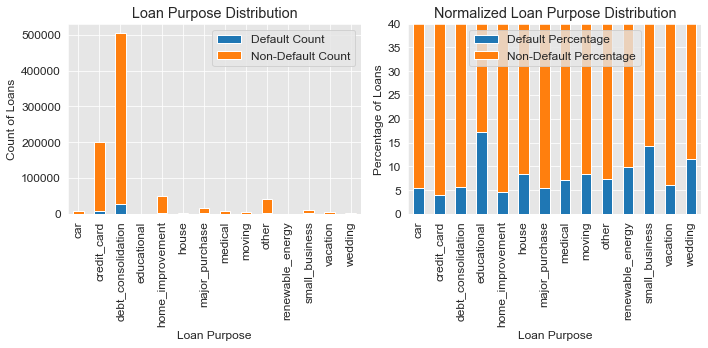

In [88]:
fig = plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 12
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax1 = fig.add_subplot(121)
viz3[['Default Count','Non-Default Count']].plot(ax=ax1, kind='bar', stacked=True)
ax1.set_title("Loan Purpose Distribution")
ax1.set_xlabel("Loan Purpose")
ax1.set_ylabel("Count of Loans")
ax1.legend()
ax2 = fig.add_subplot(122)
viz3[['Default Percentage','Non-Default Percentage']].plot(ax=ax2, kind='bar', stacked=True)
ax2.set_title("Normalized Loan Purpose Distribution")
ax2.set_xlabel("Loan Purpose")
ax2.set_ylabel("Percentage of Loans")
ax2.set_yticks([0,5,10,15,20,25,30,35,40])
ax2.set_ylim(0,40)
ax2.legend()
plt.tight_layout()
plt.savefig('loan_purpose_distribution.png')
plt.show()

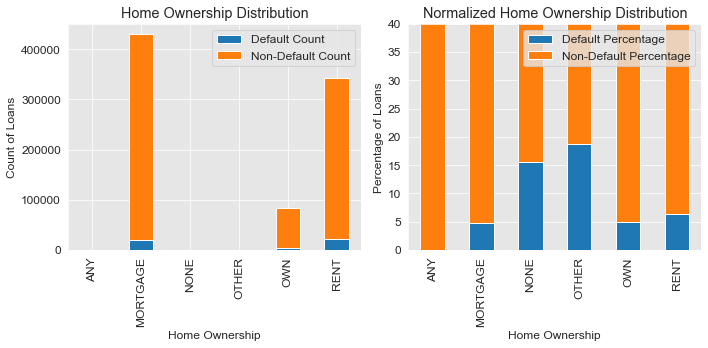

In [90]:
fig = plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 12
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax1 = fig.add_subplot(121)
viz2[['Default Count','Non-Default Count']].plot(ax=ax1, kind='bar', stacked=True)
ax1.set_title("Home Ownership Distribution")
ax1.set_xlabel("Home Ownership")
ax1.set_ylabel("Count of Loans")
ax1.legend()
ax2 = fig.add_subplot(122)
viz2[['Default Percentage','Non-Default Percentage']].plot(ax=ax2, kind='bar', stacked=True)
ax2.set_title("Normalized Home Ownership Distribution")
ax2.set_xlabel("Home Ownership")
ax2.set_ylabel("Percentage of Loans")
ax2.set_yticks([0,5,10,15,20,25,30,35,40])
ax2.set_ylim(0,40)
ax2.legend()
plt.tight_layout()
plt.savefig('home_ownership_distribution.png')
plt.show()

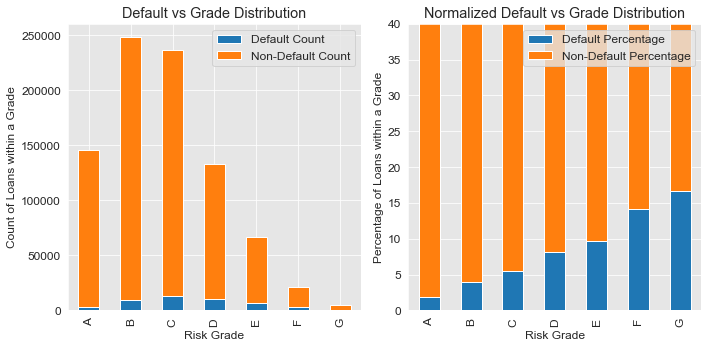

In [92]:
fig = plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 12
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax1 = fig.add_subplot(121)
viz1[['Default Count','Non-Default Count']].plot(ax=ax1, kind='bar', stacked=True)
ax1.set_title("Default vs Grade Distribution")
ax1.set_xlabel("Risk Grade")
ax1.set_ylabel("Count of Loans within a Grade")
ax1.legend()
ax2 = fig.add_subplot(122)
viz1[['Default Percentage','Non-Default Percentage']].plot(ax=ax2, kind='bar', stacked=True)
ax2.set_title("Normalized Default vs Grade Distribution")
ax2.set_xlabel("Risk Grade")
ax2.set_ylabel("Percentage of Loans within a Grade")
ax2.set_yticks([0,5,10,15,20,25,30,35,40])
ax2.set_ylim(0,40)
ax2.legend()
plt.tight_layout()
plt.savefig('risk_grade_distribution.png')
plt.show()

In [95]:
counts = dataset.select_dtypes('object').nunique()
high_cardinality_categorical_columns = list(counts[counts>15].index)
print('Potential Categorical data elements: \n', high_cardinality_categorical_columns)

for column in high_cardinality_categorical_columns:
    print('\n',dataset.groupby([column]).size())

Potential Categorical data elements: 
 ['sub_grade', 'emp_title', 'issue_d', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

 sub_grade
A1    22516
A2    22106
A3    23095
A4    33991
A5    43957
B1    44002
B2    47589
B3    54958
B4    54116
B5    47333
C1    51588
C2    50457
C3    48337
C4    46941
C5    39532
D1    34667
D2    28385
D3    25289
D4    24253
D5    20208
E1    17230
E2    15994
E3    13294
E4    11011
E5     8919
F1     6702
F2     4979
F3     4099
F4     3168
F5     2380
G1     1698
G2     1259
G3      877
G4      570
G5      469
dtype: int64

 emp_title
 \tAdv Mtr Proj Fld Rep                1
       NSA Industries llc              1
    MOTHER  THERESA  HOME              1
    Quitman Street Community School    1
   Bus Operator and Instructor         1
                                      ..
zozaya officiating                     1
zs backroom                            1
zueck transportation                   1
År.

* Sub Grade - Potentially to be translated to integers
* Emp Title - little value except for NLP
* Issue Date - to be transalted to Months since issue
* Title - little value except for NLP
* Zip Code - very high cardinality. States give much better Groupings
* Earliest Credit Line - to be translated to Months since Credit Line
* Last Payment Date - To be translated into Months since Last Payment
* Last Credit Pull Date - to be translated into Months since Last Credit Pull

In [96]:
dataset_num = dataset.select_dtypes('float64').drop('policy_code',axis = 1).copy()
dataset_num['default_ind'] = dataset['default_ind'] 

loan_amnt


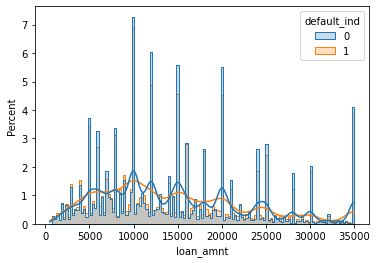

funded_amnt


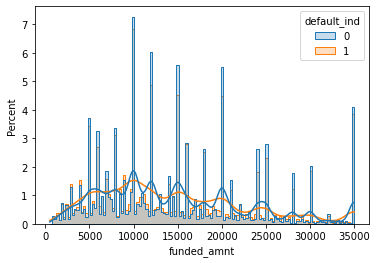

funded_amnt_inv


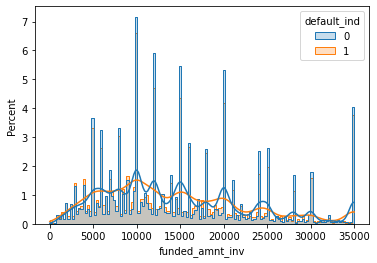

int_rate


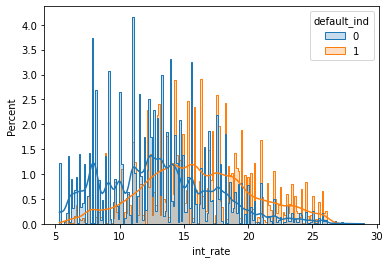

installment


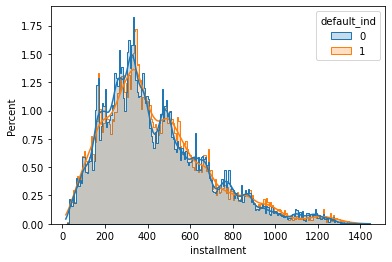

annual_inc


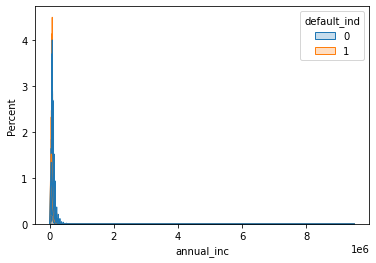

dti


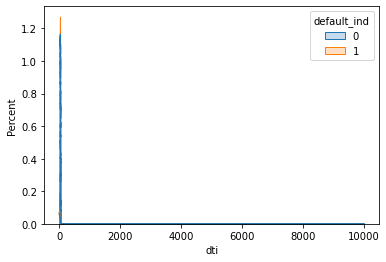

delinq_2yrs


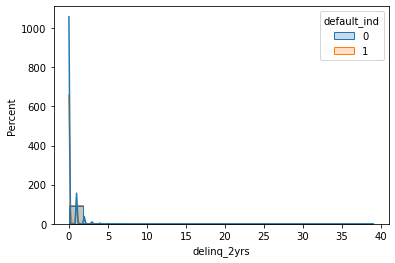

inq_last_6mths


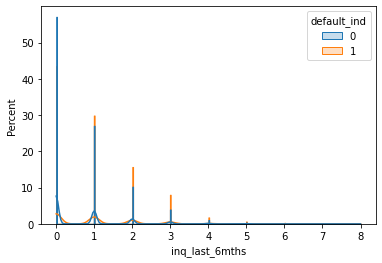

mths_since_last_delinq


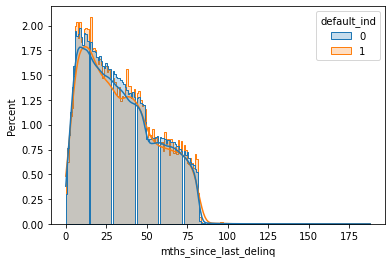

open_acc


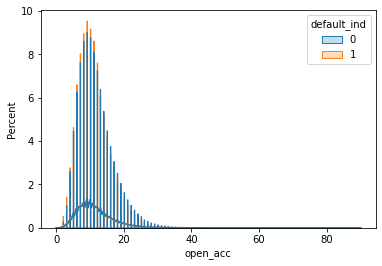

pub_rec


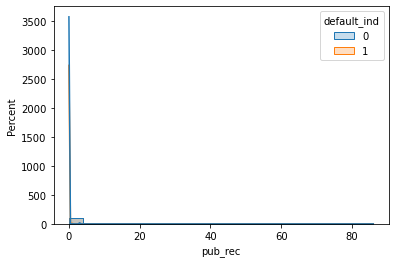

revol_bal


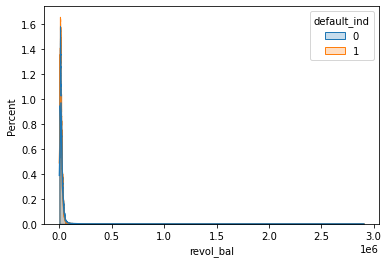

revol_util


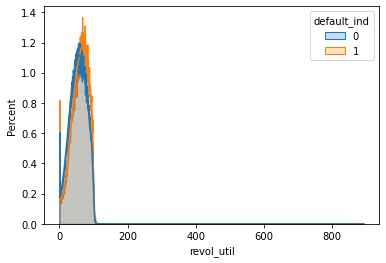

total_acc


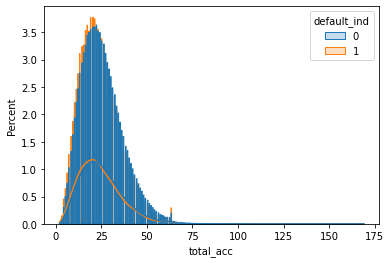

out_prncp


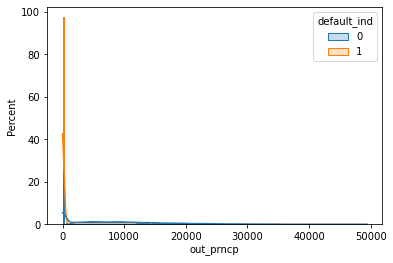

out_prncp_inv


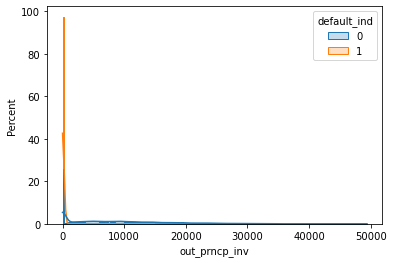

total_pymnt


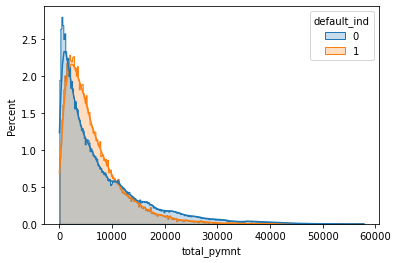

total_pymnt_inv


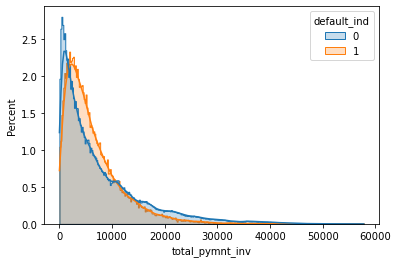

total_rec_prncp


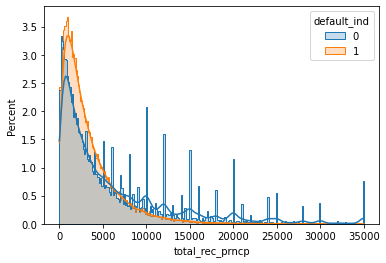

total_rec_int


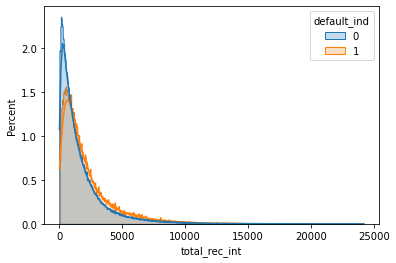

total_rec_late_fee


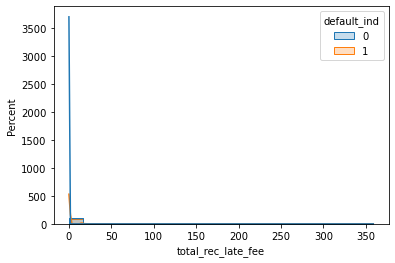

recoveries


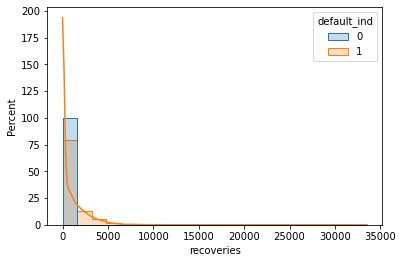

collection_recovery_fee


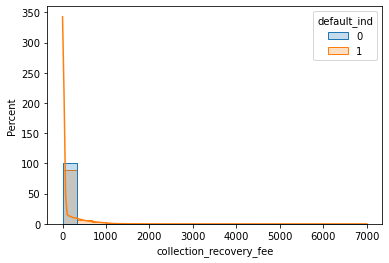

last_pymnt_amnt


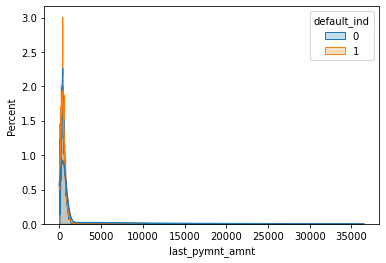

collections_12_mths_ex_med


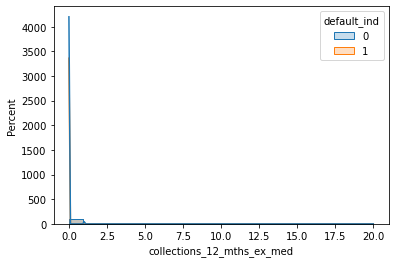

acc_now_delinq


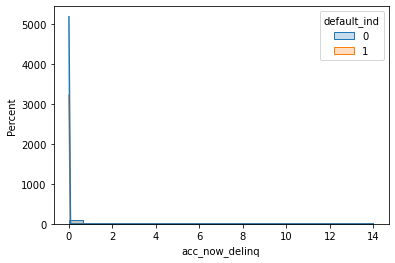

tot_coll_amt


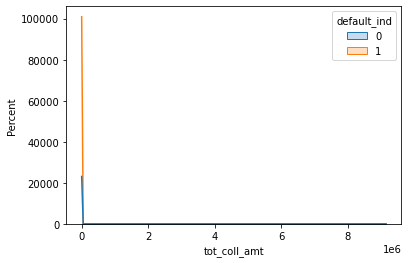

tot_cur_bal


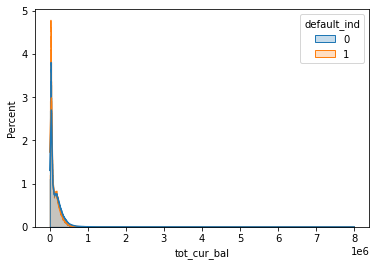

total_rev_hi_lim


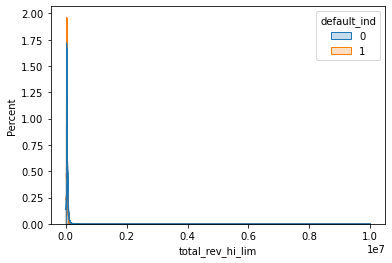

default_ind


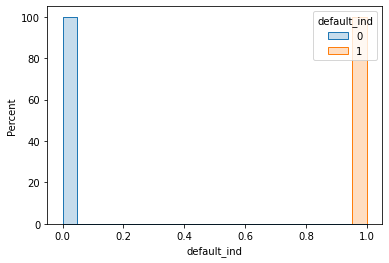

In [10]:
figures = []
for column in dataset_num:
    print(column)
    fig = norm_histplot(dataset, column)
    plt.show()
    figures.append(fig)

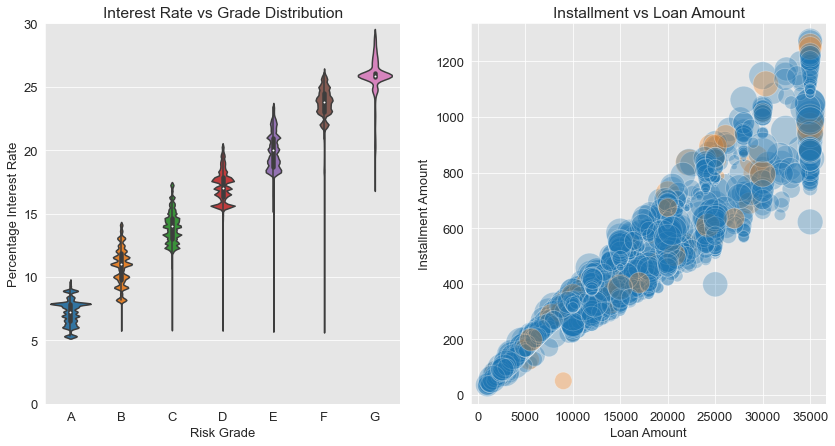

In [149]:
fig = plt.figure(figsize=(14,7))
plt.rcParams['font.size'] = 13
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax1 = fig.add_subplot(121)
sns.violinplot(x="grade", y="int_rate",data=dataset.sort_values('grade'))
ax1.set_title("Interest Rate vs Grade Distribution")
ax1.set_xlabel("Risk Grade")
ax1.set_ylabel("Percentage Interest Rate")
ax1.set_yticks([0,5,10,15,20,25,30])
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
sns.scatterplot(data=dataset.sample(frac=0.002,random_state=54), x="loan_amnt", y="installment", 
                size="int_rate",hue="default_ind", alpha=0.3,
                legend=False, sizes=(5, 1000))
ax2.set_title("Installment vs Loan Amount")
ax2.set_ylabel("Installment Amount")
ax2.set_xlabel("Loan Amount")


plt.savefig('interest_rate_and_bubble_plot.png')




In [11]:
# Clipping the values to 95% Quantile
for column in dataset_num:
    upp = dataset[column].quantile(0.975)
    low = dataset[column].quantile(0.025)
    dataset_num[column] = dataset_num[column].clip(upper = upp, lower = low)
    
counts = dataset_num.nunique()
unique_num_columns = list(counts[counts==1].index)
print(unique_num_columns)

['total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq']


In [12]:
dataset_num.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind'],
      dtype='object')

<AxesSubplot:title={'center':'Non Zero Fees'}>

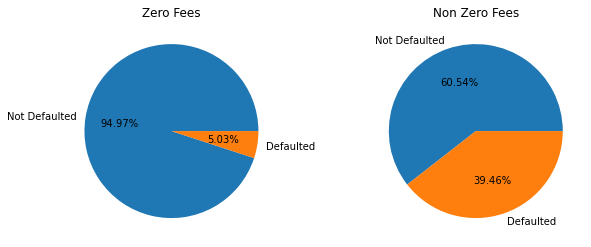

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
dataset[dataset['total_rec_late_fee']==0][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Zero Fees',autopct='%.2f%%', ax=ax1, label="")
dataset[dataset['total_rec_late_fee']>0 ][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Non Zero Fees',autopct='%.2f%%', ax=ax2, label="")

<AxesSubplot:title={'center':'Non Zero Collections'}>

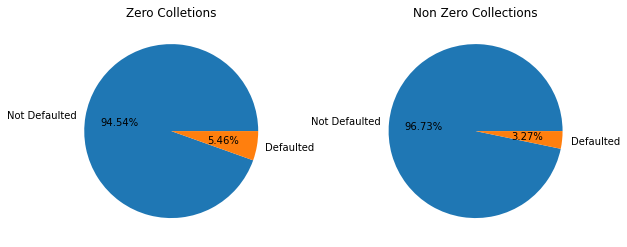

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
dataset[dataset['collections_12_mths_ex_med']==0][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Zero Colletions',autopct='%.2f%%', ax=ax1, label="")
dataset[dataset['collections_12_mths_ex_med']>0 ][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Non Zero Collections',autopct='%.2f%%', ax=ax2, label="")

<AxesSubplot:title={'center':'Non Zero Delinquent Accounts'}>

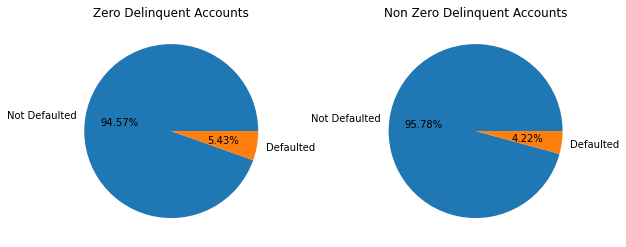

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
dataset[dataset['acc_now_delinq']==0][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Zero Delinquent Accounts',autopct='%.2f%%', ax=ax1, label="")
dataset[dataset['acc_now_delinq']>0 ][['default_ind']].value_counts().plot(kind='pie',labels=['Not Defaulted','Defaulted'],title='Non Zero Delinquent Accounts',autopct='%.2f%%', ax=ax2, label="")

In [16]:
dataset_num = dataset_num.drop(unique_num_columns, axis = 1)

loan_amnt


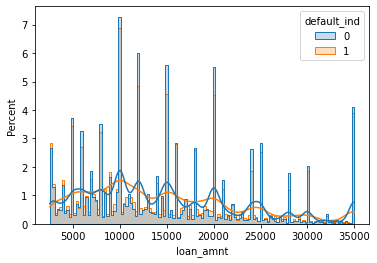

funded_amnt


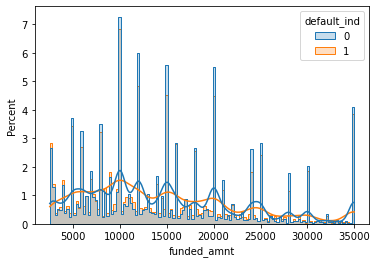

funded_amnt_inv


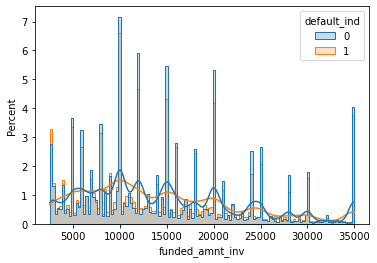

int_rate


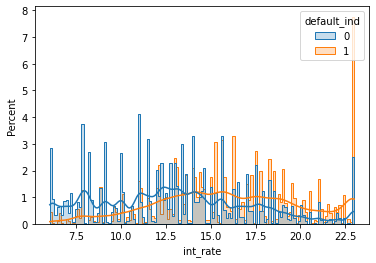

installment


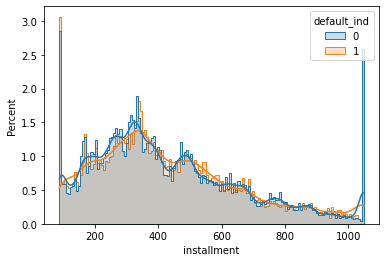

annual_inc


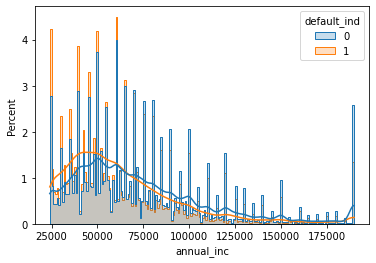

dti


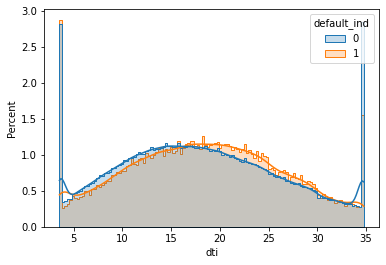

delinq_2yrs


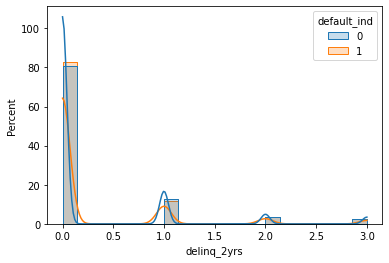

inq_last_6mths


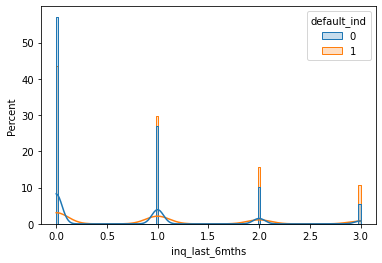

mths_since_last_delinq


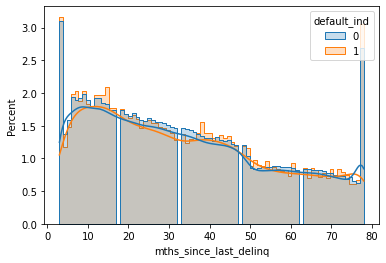

open_acc


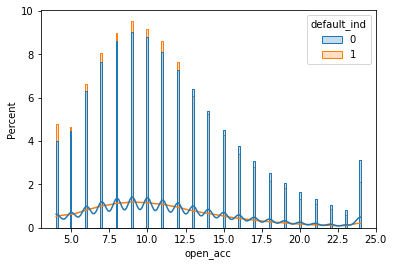

pub_rec


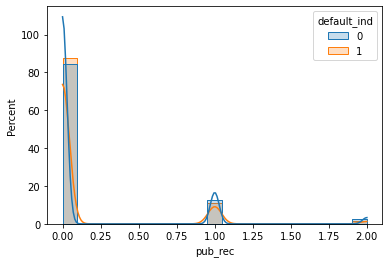

revol_bal


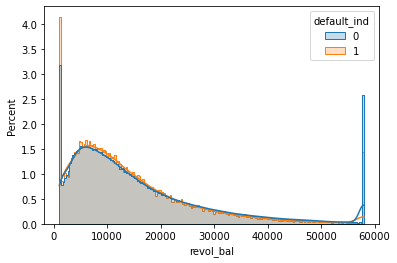

revol_util


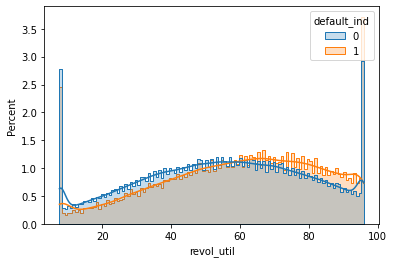

total_acc


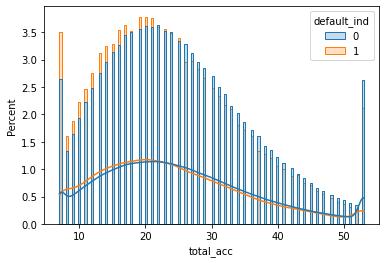

out_prncp


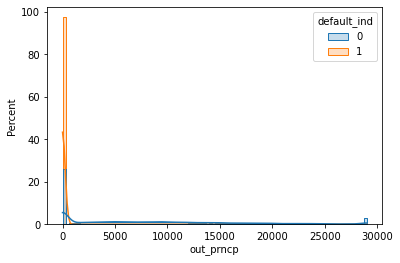

out_prncp_inv


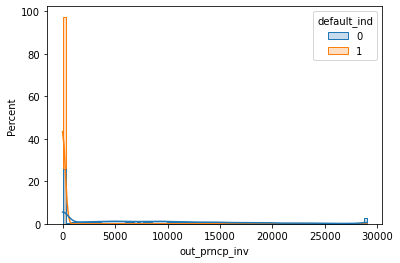

total_pymnt


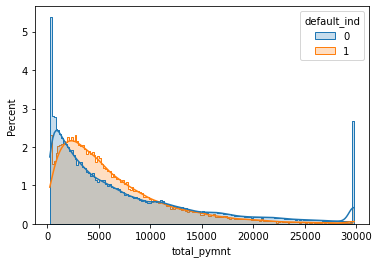

total_pymnt_inv


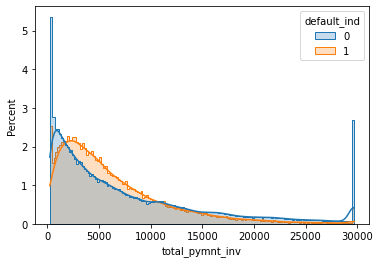

total_rec_prncp


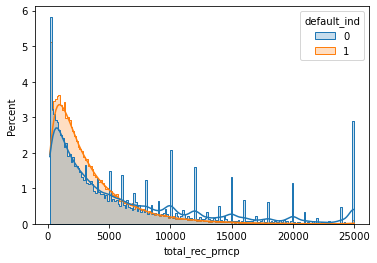

total_rec_int


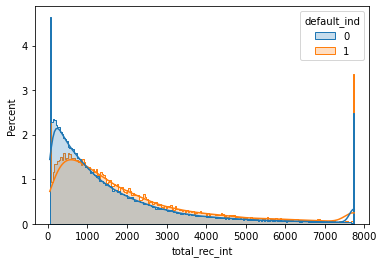

recoveries


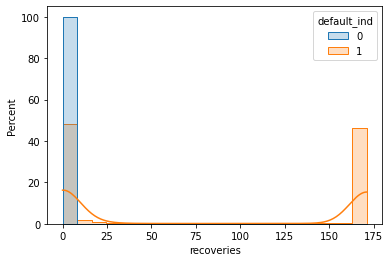

collection_recovery_fee


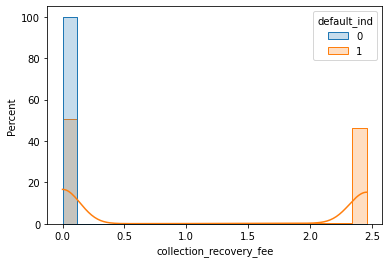

last_pymnt_amnt


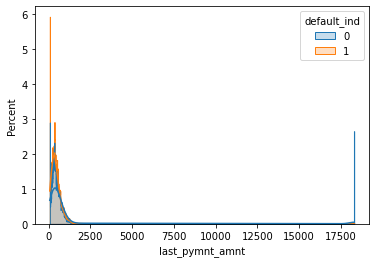

tot_coll_amt


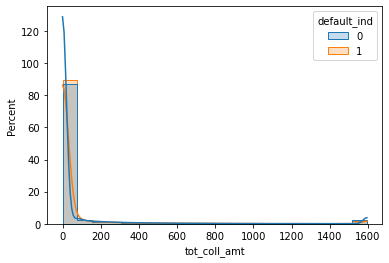

tot_cur_bal


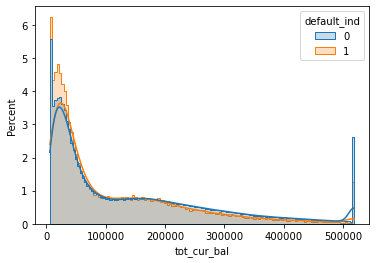

total_rev_hi_lim


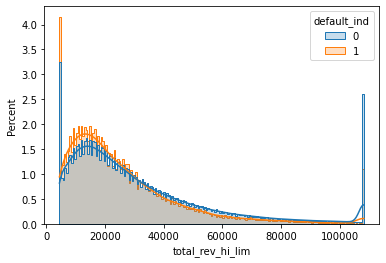

default_ind


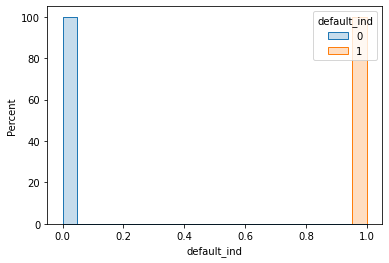

In [17]:
figures = []
for column in dataset_num:
    print(column)
    fig = norm_histplot(dataset_num, column)
    plt.show()
    figures.append(fig)

* mths_since_last_delinq - shows very little variation in distribution between default and non-default values. Fill in nulls with median
* revol_util - little nulls percentage - fill in nulls with median
* last_pymnt_d - fill in with median
* last_credit_pull_d - fill in with median
* tot_coll_amt - fill in with median